In [12]:
import time
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import hoomd
import hoomd.md
import hoomd.md.integrate

import gsd
import gsd.hoomd

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# setup the output folder with separate trajectory files for 
# the initial configuration, the optimized configuration, and the trajectory

OUT_ROOT_FOLDER = pathlib.Path('./example_traj/')
os.makedirs(OUT_ROOT_FOLDER, exist_ok=True)    

OUT_INIT_PATH = OUT_ROOT_FOLDER/'init.gsd'
OUT_OPTIMIZED_PATH = OUT_ROOT_FOLDER/'optimized.gsd'
OUT_TRAJ_PATH = OUT_ROOT_FOLDER/'traj.gsd'

In [3]:
# initialize simulation
try:
    current_device = hoomd.device.GPU()
    print(current_device.get_available_devices(), current_device.is_available())
except:
    current_device = hoomd.device.CPU()
    print('No GPU found, using CPU')


sim = hoomd.Simulation(device=current_device, seed=1)

['[0]  Tesla P100-PCIE-12GB  56 SM_6.0 @ 1.33 GHz, 12193 MiB DRAM'] True


In [4]:
## set up particles, chains (i.e bonds), and density
L_CHAIN = 40
N_CHAINS = 100
N_PARTICLES = L_CHAIN * N_CHAINS
DENSITY = 0.2

# The gsd.hoomd.Frame() object represents a snapshot or frame of a simulation in the HOOMD-blue package. 
# It contains information about the state of the system at a specific point in time. 
# This includes the positions, types, and other properties of the particles in the simulation, 
# as well as bonds, angles, and dihedrals, and the box size and other simulation parameters.
init_snapshot = gsd.hoomd.Frame()

# Initialize particles
init_snapshot.particles.N = N_PARTICLES
init_snapshot.particles.types = ["CHROMATIN"]
typeids = np.zeros(N_PARTICLES, dtype=np.int32)
init_snapshot.particles.typeid = typeids

# Periodic boundary conditions set by density
BOX_SIZE = (N_PARTICLES / DENSITY) ** (1 / 3.0)
init_snapshot.configuration.box = [BOX_SIZE, BOX_SIZE, BOX_SIZE, 0, 0, 0]

# Create initial conformation. Note that initial particles positions cannot lie outside the box.
init_positions = grow_cubic(N=N_PARTICLES, boxSize=int(BOX_SIZE - 1)).astype(float)
# center in the box
init_positions -= init_positions.mean(axis=0, keepdims=True)

# Set the initial positions of the particles.
init_snapshot.particles.position = init_positions

In [5]:
# Initialze bonds
def get_polymer_bonds(lo, hi, ring=False):
    bonds = np.vstack([np.arange(lo, hi-1), np.arange(lo+1, hi)]).T
    return bonds

polymer_bonds = np.zeros((0,2)).astype(int)
for i in range(N_CHAINS):
    lo = int(i * L_CHAIN)
    hi = int((i+1) * L_CHAIN)
    polymer_bonds = np.vstack((polymer_bonds, get_polymer_bonds(lo, hi, ring=False)))

init_snapshot.bonds.N = polymer_bonds.shape[0] 
init_snapshot.bonds.types = ['polymer']
init_snapshot.bonds.typeid = np.zeros(polymer_bonds.shape[0])
init_snapshot.bonds.group = polymer_bonds
init_snapshot.bonds.validate()

In [6]:
# The initial configuration is saved into a file to be loaded immediately.
with gsd.hoomd.open(name=OUT_INIT_PATH, mode='w') as f:
    f.append(init_snapshot)
    
sim.create_state_from_gsd(filename=OUT_INIT_PATH)

In [7]:
# creates forces
# first, add bonded forces. 
bonded_forces = hoomd.md.bond.FENEWCA()
bonded_forces.params.default = dict(
    k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0
)
# parametes can also be specified for specific bond types: 
# bonded_forces.params['polymer'] = dict(k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)


# add nonbonded forces.
# nonbonded forces are defined by a neighbor list, which is a data structure that computes and stores 
# the list of particles that are within a certain distance of each other.
nlist = hoomd.md.nlist.Cell(buffer=0.4, exclusions=("bond",))

nonbonded_forces = hoomd.md.pair.LJ(nlist=nlist, default_r_cut=1.122462048309373)
nonbonded_forces.params[("CHROMATIN", "CHROMATIN")] = {"epsilon": 1.0, "sigma": 1.0}


In [ ]:
# hoomd can compute and log thermodynamic properties of the system, such as temperature, pressure, and energy: 
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
sim.operations.computes.append(thermodynamic_properties)

In [8]:
# perform inital energy minimization with FIRE (fast internal relaxation engine)
# This helps to remove any overlaps between particles and to relax the initial configuration 
# to avoid large forces that can cause the simulation to crash.

N_FIRE_BLOCKS = 100
N_FIRE_STEPS = 1000
DT_FIRE = 0.0005

# note: we can selectitvely update the positions of a subset of particles by using a filter:
# particle_filter = hoomd.filter.Type(['CHROMATIN'])
nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())

fire = hoomd.md.minimize.FIRE(
    dt=DT_FIRE,
    force_tol=5e-2,
    angmom_tol=5e-2,
    energy_tol=5e-2,
    forces=[bonded_forces, nonbonded_forces],
    methods=[nve])
sim.operations.integrator = fire

# writing is perfomed by the gsd writer, which writes the state of the simulation to a file at regular intervals.
# these regular intervals are defined by the trigger argument of the writer and can occur inside simulation blocks 
# (althought, we are not sure about the computational cost of this operation)
gsd_optimized_writer = hoomd.write.GSD(
    filename=OUT_OPTIMIZED_PATH,
    trigger=hoomd.trigger.Periodic(N_FIRE_STEPS),
    mode='wb')
sim.operations.writers.append(gsd_optimized_writer)

# we need to run the simulation (even if for 0 steps) to apply the forces and compute the thermodynamic properties
sim.run(0)
print(f'kin temp = {thermodynamic_properties.kinetic_temperature:3},  E_P/N = {thermodynamic_properties.potential_energy / N_PARTICLES}')

for i in range(N_FIRE_BLOCKS):
    sim.run(N_FIRE_STEPS)
    print(f'kin temp = {thermodynamic_properties.kinetic_temperature},   E_P/N = {thermodynamic_properties.potential_energy / N_PARTICLES}')
    gsd_optimized_writer.write(sim.state, gsd_optimized_writer.filename)

# remove the forces and writers from the integrator
# so that they can be attached to the new integrator
for _ in range(len(fire.forces)):
    fire.forces.pop()
sim.operations.writers.pop(0)

# FIRE reduces the kinetic energy of particles, so we need to re-thermalize the system
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)


kin temp = 0.0,  E_P/N = 20.316854942080845
kin temp = 0.0184596224565914,   E_P/N = 18.904769953475682
kin temp = 0.020210607858283214,   E_P/N = 19.356438095559334
kin temp = 0.021186432046966807,   E_P/N = 19.442224558011265
kin temp = 0.021624500574360696,   E_P/N = 19.50306762103946
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.0007456163133933608,   E_P/N = 19.515074296139275
kin temp = 0.00074

In [9]:
# setup LANGEVIN dynamics

# langevin integrator parameters
NUM_BLOCKS = 100
BLOCK_SIZE = 10000
LANGEVIN_TIMESTEP = 0.01

# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)

run_integrator = hoomd.md.Integrator(
    dt=LANGEVIN_TIMESTEP, 
    methods=[langevin], 
    forces=[bonded_forces, nonbonded_forces])
sim.operations.integrator = run_integrator

gsd_writer = hoomd.write.GSD(
    filename=OUT_TRAJ_PATH,
    trigger=hoomd.trigger.Periodic(BLOCK_SIZE),
    dynamic=['property','momentum'],
    mode='wb')

sim.operations.writers.append(gsd_writer)


In [10]:
# run langevin dynamics

for i in range(0, NUM_BLOCKS):
    start=time.time()
    sim.run(BLOCK_SIZE)
    print(f'kin temp = {thermodynamic_properties.kinetic_temperature}, E_P/N = {thermodynamic_properties.potential_energy / N_PARTICLES}')



kin temp = 1.020205643714926, E_P/N = 20.15411725411866
kin temp = 1.0025392899061423, E_P/N = 20.15410961724387
kin temp = 1.0054529604815148, E_P/N = 20.14448771454303
kin temp = 1.0002674440681798, E_P/N = 20.141082225832992
kin temp = 0.9954118427371368, E_P/N = 20.132828602470706
kin temp = 1.0020473641192287, E_P/N = 20.1772784858429
kin temp = 0.9824128122424465, E_P/N = 20.168358364321787
kin temp = 0.9874192059737293, E_P/N = 20.16583865314167
kin temp = 1.004146035985465, E_P/N = 20.172571843044874
kin temp = 0.9951233248288452, E_P/N = 20.166690385942495
kin temp = 1.0015096346918417, E_P/N = 20.17605013277004
kin temp = 0.9950609458170182, E_P/N = 20.15555295652492
kin temp = 0.9926715405978993, E_P/N = 20.154279483563695
kin temp = 0.9880670955500415, E_P/N = 20.169713948179588
kin temp = 0.9888129796131253, E_P/N = 20.13347678611669
kin temp = 1.0055974246264674, E_P/N = 20.131545939950442
kin temp = 1.0007046954604164, E_P/N = 20.184727996467696
kin temp = 0.985253464156

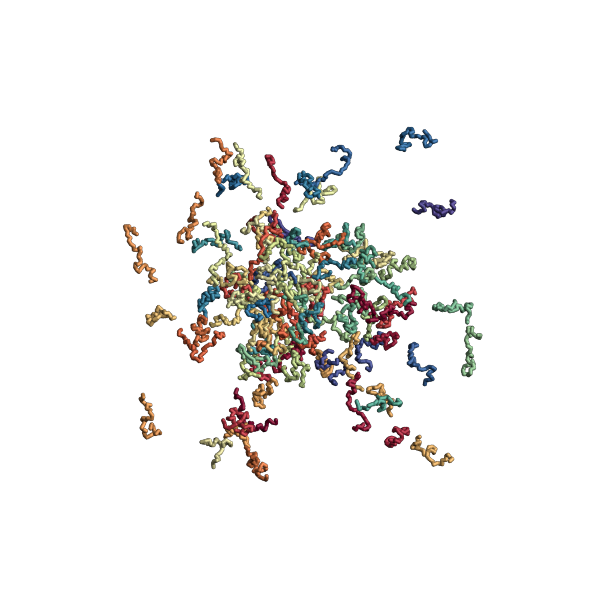

In [11]:
import polychrom_hoomd.render as render
snapshot_relaxed= sim.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="Spectral").static(pathtrace=False)

